<a href="https://colab.research.google.com/github/ankitkomar1/STUDENT/blob/master/uzzy_vector_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 6.6MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.1-cp36-none-any.whl size=894065 sha256=150341bcc904140d179964a50174236e238e0d5ce119fb854fd41119b8bd587d
  Stored in directory: /root/.cache/pip/wheels/9d/f9/0e/a8de3e98e64bbf828f5e762936ff5a40e72331dbe663470711
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
#from mnist import MNIST
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz
import itertools
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.datasets import fetch_openml
#sns.set(style='white', context='poster')
#import umap
#import umap.umap_ as umap
from scipy.stats import mode
from collections import Counter
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [ ]:
def normalize(vector):
    """
    Return the vector, normalized.
    If vector is 2d, treats it as stacked vectors, and normalizes each one.
    """
    if vector.ndim == 1:
        return vector / np.linalg.norm(vector)
    elif vector.ndim == 2:
        return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]
    else:
        raise_dimension_error(vector)

def magnitude(vector):
    """
    Compute the magnitude of `vector`. For stacked inputs, compute the magnitude
    of each one.
    Args:
        vector (np.arraylike): A `3x1` vector or a `kx3` stack of vectors.
    Returns:
        object: For `3x1` inputs, a `float` with the magnitude. For `kx1`
            inputs, a `kx1` array.
    """
    if vector.ndim == 1:
        return np.linalg.norm(vector)
    elif vector.ndim == 2:
        return np.linalg.norm(vector, axis=1)
    else:
        raise_dimension_error(vector)


# Alias because angle()'s parameter shadows the name.
_normalize = normalize


def angle(v1, v2, look=None, assume_normalized=False, units="deg"):
    """
    Compute the unsigned angle between two vectors. For stacked inputs, the
    angle is computed pairwise.
    When `look` is provided, the angle is computed in that viewing plane
    (`look` is the normal). Otherwise the angle is computed in 3-space.
    Args:
        v1 (np.arraylike): A `3x1` vector or a `kx3` stack of vectors.
        v2 (np.arraylike): A vector or stack of vectors with the same shape as
            `v1`.
        look (np.arraylike): A `3x1` vector specifying the normal of a viewing
            plane, or `None` to compute the angle in 3-space.
        assume_normalized (bool): When `True`, assume the input vectors
            are unit length. This improves performance, however when the inputs
            are not normalized, setting this will cause an incorrect results.
        units (str): `'deg'` to return degrees or `'rad'` to return radians.
    Return:
        object: For `3x1` inputs, a `float` with the angle. For `kx1` inputs,
            a `kx1` array.
    """
    if units not in ["deg", "rad"]:
        raise ValueError("Unrecognized units {}; expected deg or rad".format(units))

    if look is not None:
        # This is a simple approach. Since this is working in two dimensions,
        # a smarter approach could reduce the amount of computation needed.
        v1, v2 = [reject(v, from_v=look) for v in (v1, v2)]

    dot_products = np.einsum("ij,ij->i", v1.reshape(-1, 3), v2.reshape(-1, 3))

    if assume_normalized:
        cosines = dot_products
    else:
        cosines = dot_products / magnitude(v1) / magnitude(v2)

    # Clip, because the dot product can slip past 1 or -1 due to rounding and
    # we can't compute arccos(-1.00001).
    angles = np.arccos(np.clip(cosines, -1.0, 1.0))
    if units == "deg":
        angles = np.degrees(angles)

    return angles[0] if v1.ndim == 1 and v2.ndim == 1 else angles


def uniform_midtread_quantizer(x, Q):
    '''
    x: input array
    Q: quantization step
    '''
    # limiter
    x = np.copy(x)
    idx = np.where(np.abs(x) >= 1)
    x[idx] = np.ones(x[idx].shape)
    # linear uniform quantization
    xQ = np.round(Q * np.floor(x/Q + 1/2),6)

    return xQ

def fuzzified(s,m,l):
    V_fuzzified=[]

    for i in range(len(s)):
        V_fuzzified.append([ ])

    for i in range(len(s)):
        f=[s[i],m[i],l[i]]
        #f1=np.asarray(f1)
        V_fuzzified[i].append(f)
    return np.squeeze(V_fuzzified,axis=1)



def mostCommon(lst):

    return [Counter(col).most_common(1)[0][0] for col in zip(*lst)]



def mostCommon1(lst):

	val, count = mode(lst, axis = 0)
	return val.ravel().tolist()


def euclidistance(arr1,arr2):
        return np.linalg.norm(arr1-arr2)


In [ ]:
iris = datasets.load_iris()

In [ ]:
df = pd.DataFrame(data= np.c_[iris['target'], iris['data']],
                     columns= ['target']+iris['feature_names'])

In [ ]:
df.iloc[40:60,0:1]

,target
40,0.0
41,0.0
42,0.0
43,0.0
44,0.0
45,0.0
46,0.0
47,0.0
48,0.0
49,0.0


# Data normalization

In [ ]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset=pd.DataFrame(x_scaled, columns=df.columns)

dataset.iloc[0:50,0:1]=0
dataset.iloc[50:100,0:1]=1
dataset.iloc[100:150,0:1]=2

In [ ]:
dataset.iloc[40:60,:]

,target,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
40,0.0,0.194444,0.625000,0.050847,0.083333
41,0.0,0.055556,0.125000,0.050847,0.083333
42,0.0,0.027778,0.500000,0.050847,0.041667
43,0.0,0.194444,0.625000,0.101695,0.208333
44,0.0,0.222222,0.750000,0.152542,0.125000
45,0.0,0.138889,0.416667,0.067797,0.083333
46,0.0,0.222222,0.750000,0.101695,0.041667
47,0.0,0.083333,0.500000,0.067797,0.041667
48,0.0,0.277778,0.708333,0.084746,0.041667
49,0.0,0.194444,0.541667,0.067797,0.041667


# Seperating the classes

In [ ]:
for i in range(3):
    locals()["class"+str(i)+"_index"] = dataset.loc[dataset['target']==i].index.values
    locals()["class"+str(i)] = dataset.iloc[locals()["class"+str(i)+"_index"],:]

In [ ]:
class0.shape

(50, 5)

In [ ]:
max1 = max(max(dataset.iloc[:,1]),max(dataset.iloc[:,2]),max(dataset.iloc[:,3]),max(dataset.iloc[:,4]))
min1 = min(min(dataset.iloc[:,1]),min(dataset.iloc[:,2]),min(dataset.iloc[:,3]),min(dataset.iloc[:,4]))

In [ ]:
a=([np.asarray(dataset.iloc[:,1])],[np.asarray(dataset.iloc[:,2])],[np.asarray(dataset.iloc[:,3])],[np.asarray(dataset.iloc[:,4])])
b=np.squeeze(a, axis=1)
c=np.asarray(b).reshape(600,1)
c.shape

(600, 1)

In [ ]:
sigma1=np.std(c[:,0])


mid=np.median(c[:,0])
midd=np.mean(c[:,0])
middd=( ( max(c[:,0])- min(c[:,0]) ) /2)

<function matplotlib.pyplot.show>

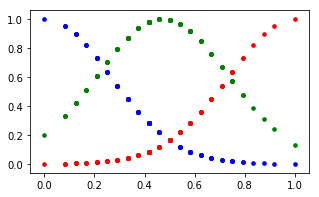

In [ ]:
#x_qual = np.arange(min(iris.data[:,0]), max(iris.data[:,0]), 0.05)

qual_lo = fuzz.gaussmf((dataset.iloc[:,2]), min(dataset.iloc[:,2]), sigma1)
qual_md = fuzz.gaussmf((dataset.iloc[:,2]),mid, sigma1)
qual_hi = fuzz.gaussmf((dataset.iloc[:,2]),max(dataset.iloc[:,2]), sigma1)

plt.figure(figsize=(5,3))

plt.scatter((dataset.iloc[:,2]), qual_lo, c='b', linewidth=1.5, s=10, label='small')
plt.scatter((dataset.iloc[:,2]), qual_md, c='g', linewidth=1.5, s=10, label='medium')
plt.scatter((dataset.iloc[:,2]), qual_hi, c='r', linewidth=1.5, s=10, label='large')

#plt.legend()
plt.show


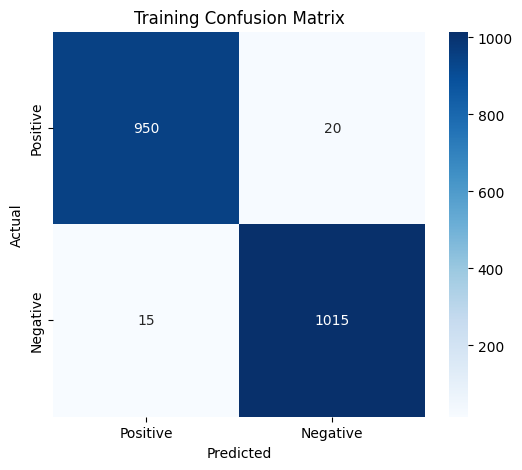

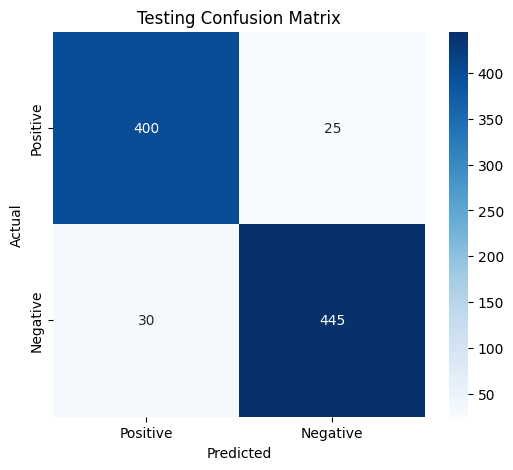

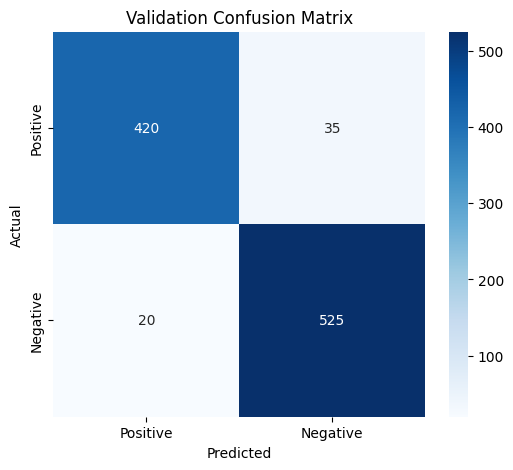

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data for confusion matrices
data = {
    "Training": np.array([[950, 20], [15, 1015]]),
    "Testing": np.array([[400, 25], [30, 445]]),
    "Validation": np.array([[420, 35], [20, 525]])
}

# Plot confusion matrices
for dataset, matrix in data.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.title(f"{dataset} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
V1 = np.asarray(class0.iloc[:,1:5])
V2 = np.asarray(class1.iloc[:,1:5])
V3 = np.asarray(class2.iloc[:,1:5])

# Fuzzification

s0 = fuzz.membership.gaussmf(V1, min1, sigma1)
m0 = fuzz.membership.gaussmf(V1, mid, sigma1)
l0 = fuzz.membership.gaussmf(V1, max1, sigma1)

s1 = fuzz.membership.gaussmf(V2, min1, sigma1)
m1 = fuzz.membership.gaussmf(V2, mid, sigma1)
l1 = fuzz.membership.gaussmf(V2, max1, sigma1)

s2 = fuzz.membership.gaussmf(V3, min1, sigma1)
m2 = fuzz.membership.gaussmf(V3,mid, sigma1)
l2 = fuzz.membership.gaussmf(V3,max1, sigma1)



In [ ]:
s0.shape

(50, 4)

In [ ]:
V0_fuzzified = []
for i in range(50):
    V0_fuzzified.append([ ])

for i in range(50):

    f0=[[s0[i,0],m0[i,0],l0[i,0]],[s0[i,1],m0[i,1],l0[i,1]],[s0[i,2],m0[i,2],l0[i,2]],[s0[i,3],m0[i,3],l0[i,3]]]

    V0_fuzzified[i].append(f0)

V0_fuzzified = np.squeeze((np.asarray(V0_fuzzified)), axis=1)

In [ ]:
V1_fuzzified = []
for i in range(50):
    V1_fuzzified.append([ ])

for i in range(50):

    f1=[[s1[i,0],m1[i,0],l1[i,0]],[s1[i,1],m1[i,1],l1[i,1]],[s1[i,2],m1[i,2],l1[i,2]],[s1[i,3],m1[i,3],l1[i,3]]]

    V1_fuzzified[i].append(f1)

V1_fuzzified = np.squeeze((np.asarray(V1_fuzzified)), axis=1)

In [ ]:
V2_fuzzified = []
for i in range(50):
    V2_fuzzified.append([ ])

for i in range(50):

    f2=[[s2[i,0],m2[i,0],l2[i,0]],[s2[i,1],m2[i,1],l2[i,1]],[s2[i,2],m2[i,2],l2[i,2]],[s2[i,3],m2[i,3],l2[i,3]]]

    V2_fuzzified[i].append(f2)

V2_fuzzified = np.squeeze((np.asarray(V2_fuzzified)), axis=1)

In [ ]:
print((V0_fuzzified).shape)
print((V1_fuzzified).shape)
print((V2_fuzzified).shape)

(50, 4, 3)
(50, 4, 3)
(50, 4, 3)


In [ ]:
d=[]
s=[]
for i in range(5,100,1):
    step_size = 1/i
    V0_fuzz = uniform_midtread_quantizer(V0_fuzzified, step_size)
    V1_fuzz = uniform_midtread_quantizer(V1_fuzzified, step_size)
    V2_fuzz = uniform_midtread_quantizer(V2_fuzzified, step_size)

    V0_fuzzlist = V0_fuzz.tolist()
    V1_fuzzlist = V1_fuzz.tolist()
    V2_fuzzlist = V2_fuzz.tolist()

    max_v0=max(V0_fuzzlist, key=V0_fuzzlist.count)
    max_v1=max(V1_fuzzlist, key=V1_fuzzlist.count)
    max_v2=max(V2_fuzzlist, key=V2_fuzzlist.count)

    numbers = [max_v0, max_v1, max_v2]
    xc = np.asarray(list(itertools.combinations(numbers, 2)))



    def euclidistance(arr1,arr2):
        return np.linalg.norm(arr1-arr2)

    distance=[]
    for i in range(len(xc)):
        dis = euclidistance(xc[i,0,:],xc[i,1,:])
        if dis != 0:
            distance.append(dis)
        else:
            distance.clear()
            break

#    vect_dist1 = np.linalg.norm(np.asarray(max_v3) - np.asarray(max_v2))
#    vect_dist2 = np.linalg.norm(np.asarray(max_v2) - np.asarray(max_v1))
#    vect_dist3 = np.linalg.norm(np.asarray(max_v3) - np.asarray(max_v1))

#    distance=[vect_dist1,vect_dist2,vect_dist3]

    ss=sum(distance)
    d.append(distance)
    s.append(ss)
    print(ss)

4.7337618278914
4.900826477029252
4.901854861527974
4.9837188228406735
4.962103836722352
4.759217249415712
5.094253216894248
4.867679678549151
4.879817399520034
5.113996241207397
4.859859156632309
4.783063182410019
4.802886200040915
4.763685853960647
4.758130044811356
4.830186512494174
4.80417915639952
4.734003590472819
4.779949730543438
4.7769023014654515
4.767616873221126
4.7863442054617025
4.814762909914368
4.801236319580777
4.749094681985119
4.716046865836975
4.773590251286765
4.736276642824561
4.765480938107639
4.7905854200967015
4.746954925276573
4.768081399591393
4.7715256877501995
4.769494301877238
4.806532959075909
4.760118956779218
4.77698699513204
4.763714635142504
4.7446241507761915
4.756333889992533
4.7384554285089004
4.735347642519184
4.731607995422073
4.725888938261692
4.723635381029063
4.750593242986943
4.732727414584739
4.736685278285029
4.766648306570313
4.732900769220709
4.75444544982522
4.752853806125539
4.760278974440077
4.758882540934392
4.745642181996201
4.758789

In [ ]:
sum_dist=pd.DataFrame(s)

sum_index = sum_dist.loc[sum_dist[0]!=0].index.values
sum_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94])

In [ ]:
max_value = max(s)
max_index = s.index(max_value)
max_index

9

In [ ]:
%%time
pred_label=[]
for j in sum_index:
    step_size = 1/(j+5)
    for i in range(3):
        locals()["V"+str(i)+"_fuzz"] = (uniform_midtread_quantizer(locals()["V"+str(i)+"_fuzzified"], step_size)).reshape(50,12)

    for i in range(3):
        locals()["V"+str(i)+"_fuzzlist"] = locals()["V"+str(i)+"_fuzz"].tolist()

    for i in range(3):
        locals()["max_v"+str(i)] = mostCommon(locals()["V"+str(i)+"_fuzzlist"])    #Centroids of 3 clusters

                                                                                   #(3 flower species)

    for i in range(150):

        V_n = np.asarray(dataset.iloc[i,1:5])

        s_n = fuzz.membership.gaussmf(V_n, min1, sigma1)
        m_n = fuzz.membership.gaussmf(V_n, mid, sigma1)
        l_n = fuzz.membership.gaussmf(V_n, max1, sigma1)


        V_n_fuzzified=[s_n[0],m_n[0],l_n[0], s_n[1],m_n[1],l_n[1], s_n[2],m_n[2],l_n[2], s_n[3],m_n[3],l_n[3]]

        V_n_fuzzified=np.asarray(V_n_fuzzified)

        V_n_fuzz = uniform_midtread_quantizer(V_n_fuzzified, step_size)

        for i in range(3):
            locals()["angle"+str(i)]=angle(V_n_fuzz, np.asarray(locals()["max_v"+str(i)]),look=None, units="deg")


        predict={"0":angle0, "1":angle1, "2":angle2}

        for key, val in predict.items():
            if val == min(predict.values()):
                k=key
        pred_label.append(k)


    print(accuracy_score((iris.target).astype(int), np.asarray(pred_label).astype(int) ))
    locals()["accuracy"+str(j)] = (accuracy_score((iris.target).astype(int), np.asarray(pred_label).astype(int) ))
    locals()["prediction"+str(j)]=np.asarray(pred_label)
    pred_label.clear()


0.68
0.6533333333333333
0.6
0.66
0.56
0.7466666666666667
0.6266666666666667
0.68
0.6266666666666667
0.6266666666666667
0.6866666666666666
0.6266666666666667
0.5933333333333334
0.6866666666666666
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.66
0.5933333333333334
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.5933333333333334
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.64
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.5933333333333334
0.64
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.64
0.6266666666666667
0.64
0.64
0.64
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.6266666666666667
0.64
0.6266666666666667
0.6266666666666667
0.626

In [ ]:
np.asarray(V_n_fuzz).shape

(12,)

In [ ]:
np.asarray(max_v0).shape

(12,)

In [ ]:
angle( np.asarray(V_n_fuzz), np.asarray(max_v0),assume_normalized=False,  look=None, units="deg" )

77.6268947097396

In [ ]:
accuracy0

0.68

In [ ]:
accu=[]
for j in sum_index:
    p = [locals()["accuracy"+str(j)]]
    accu.append(p)

(max(accu))

[0.7466666666666667]

# by magnitude

In [ ]:
V1_mag = np.linalg.norm( np.asarray(class0.iloc[:,1:5]), axis = 1 )
V2_mag = np.linalg.norm( np.asarray(class1.iloc[:,1:5]), axis = 1 )
V3_mag = np.linalg.norm( np.asarray(class2.iloc[:,1:5]), axis = 1 )

In [ ]:
#print(V1_mag[0])
print( np.sqrt(class0.iloc[0,1]**2 + class0.iloc[0,2]**2 + class0.iloc[0,3]**2 + class0.iloc[0,4]**2)  )
#print(class0.iloc[0:1,1:2])

0.6680869760075913


In [ ]:
mag = [ [V1_mag], [V2_mag], [V3_mag] ]
#mag

b_mag=np.squeeze(mag, axis=1)
c_mag=np.asarray(b_mag).reshape(150,1)
c_mag.shape

(150, 1)

In [ ]:
sigma=np.std(c[:,0])

max_mag = max(c_mag[:,0])
min_mag = min(c_mag[:,0])

mid_mag = np.median(c_mag[:,0])
midd_mag = np.mean(c_mag[:,0])
middd_mag = ( ( max(c_mag[:,0])- min(c_mag[:,0]) ) /2)

In [ ]:
_

# Fuzzification

s0_mag = fuzz.membership.gaussmf(V1_mag, min_mag, sigma)
m0_mag = fuzz.membership.gaussmf(V1_mag, mid_mag, sigma)
l0_mag = fuzz.membership.gaussmf(V1_mag, max_mag, sigma)

s1_mag = fuzz.membership.gaussmf(V2_mag, min_mag, sigma)
m1_mag = fuzz.membership.gaussmf(V2_mag, mid_mag, sigma)
l1_mag = fuzz.membership.gaussmf(V2_mag, max_mag, sigma)

s2_mag = fuzz.membership.gaussmf(V3_mag, min_mag, sigma)
m2_mag = fuzz.membership.gaussmf(V3_mag, mid_mag, sigma)
l2_mag = fuzz.membership.gaussmf(V3_mag, max_mag, sigma)


In [ ]:
s0_mag.shape

(50,)

In [ ]:
V0_mag_fuzzified = []
V1_mag_fuzzified = []
V2_mag_fuzzified = []

for i in range(50):
  f0_mag = [ s0_mag[i], m0_mag[i], l0_mag[i] ]
  V0_mag_fuzzified.append(f0_mag)

V0_mag_fuzzified = (np.asarray(V0_mag_fuzzified))

for i in range(50):
  f1_mag = [ s1_mag[i], m1_mag[i], l1_mag[i] ]
  V1_mag_fuzzified.append(f1_mag)

V1_mag_fuzzified = (np.asarray(V1_mag_fuzzified))

for i in range(50):
  f2_mag = [ s2_mag[i], m2_mag[i], l2_mag[i] ]
  V2_mag_fuzzified.append(f2_mag)

V2_mag_fuzzified = (np.asarray(V2_mag_fuzzified) )

In [ ]:
print((V0_mag_fuzzified).shape)
print((V1_mag_fuzzified).shape)
print((V2_mag_fuzzified).shape)

(50, 3)
(50, 3)
(50, 3)


In [ ]:
d_mag=[]
s_mag=[]
for i in range(5,100,1):
  step_size = 1/i
  V0_mag_fuzz = uniform_midtread_quantizer(V0_mag_fuzzified, step_size)
  V1_mag_fuzz = uniform_midtread_quantizer(V1_mag_fuzzified, step_size)
  V2_mag_fuzz = uniform_midtread_quantizer(V2_mag_fuzzified, step_size)

  V0_mag_fuzzlist = V0_mag_fuzz.tolist()
  V1_mag_fuzzlist = V1_mag_fuzz.tolist()
  V2_mag_fuzzlist = V2_mag_fuzz.tolist()

  max_mag_v0=max(V0_mag_fuzzlist, key=V0_mag_fuzzlist.count)
  max_mag_v1=max(V1_mag_fuzzlist, key=V1_mag_fuzzlist.count)
  max_mag_v2=max(V2_mag_fuzzlist, key=V2_mag_fuzzlist.count)

  numbers_mag = [max_mag_v0, max_mag_v1, max_mag_v2]
  xc_mag = np.asarray(list(itertools.combinations(numbers_mag, 2)))



  def euclidistance(arr1,arr2):
    return np.linalg.norm(arr1-arr2)

  distance_mag=[]
  for i in range(len(xc)):
    dis_mag = euclidistance(xc_mag[i,0,:], xc_mag[i,1,:])
    if dis_mag != 0:
      distance_mag.append(dis_mag)
    else:
      distance_mag.clear()
      break

#    vect_dist1 = np.linalg.norm(np.asarray(max_v3) - np.asarray(max_v2))
#    vect_dist2 = np.linalg.norm(np.asarray(max_v2) - np.asarray(max_v1))
#    vect_dist3 = np.linalg.norm(np.asarray(max_v3) - np.asarray(max_v1))

#    distance=[vect_dist1,vect_dist2,vect_dist3]

  ss_mag=sum(distance_mag)
  d_mag.append(distance_mag)
  s_mag.append(ss_mag)
  print(ss_mag)

1.2796691275336338
1.0663912292831148
0.9140484627603618
1.035672910723255
1.9204865236062738
1.3143198992792389
1.92654086102791
1.095266618996268
1.011014296122569
1.0709575698371239
1.001664768855948
1.8859093396448543
1.0366096868801422
1.0795249593713574
1.0227074269874212
1.0672871058826738
1.016462893900541
1.2907081261205464
1.0413846177786061
1.073842742953679
1.030888650651647
1.065403518788012
1.2872906017155867
1.0712594273343838
1.8294121061610846
1.0851461106398061
1.0501406901293624
1.0764195820680473
1.043799763053057
1.35041188736846
1.3118284012503187
1.0795249593713574
2.1384799977754128
1.0728853756214627
1.0453740495147086
1.0654388800475645
0.9879718856495339
1.0253200148876822
1.0029939740529772
1.0220129021771784
0.9993015454990258
1.0608262783604467
1.0453458592750293
1.0771367285529787
1.0571466104687
1.0725150535527468
1.0514855834472605
1.0666758401010927
1.0465498282158914
1.0767414860845368
1.2989364080598889
1.070944387403297
1.052156490320432
1.065787919

In [ ]:
%matplotlib notebook

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['figure.dpi']=100
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(V0_mag_fuzzified[:, 0], V0_mag_fuzzified[:, 1], V0_mag_fuzzified[:, 2], c='r', cmap='Spectral', s=5)
ax.scatter(V1_mag_fuzzified[:, 0], V1_mag_fuzzified[:, 1], V1_mag_fuzzified[:, 2], c='g', cmap='Spectral', s=5)
ax.scatter(V2_mag_fuzzified[:, 0], V2_mag_fuzzified[:, 1], V2_mag_fuzzified[:, 2], c='b', cmap='Spectral', s=5)


ax.scatter(max_mag_v0[0], max_mag_v0[1], max_mag_v0[2], c='r', cmap='Spectral', s=50, label='Setosa')
ax.scatter(max_mag_v1[0], max_mag_v1[1], max_mag_v1[2], c='g', cmap='Spectral', s=50, label='Versicolour')
ax.scatter(max_mag_v2[0], max_mag_v2[1], max_mag_v2[2], c='b', cmap='Spectral', s=50, label='Virginica')


ax.scatter(0, 0, 0, c='k', s=50)
#plt.gca().set_aspect('equal', 'datalim')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Iris Data fuzzified and quantized', fontsize=24)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sum_dist_mag=pd.DataFrame(s_mag)

sum_index_mag = sum_dist_mag.loc[sum_dist_mag[0]!=0].index.values
sum_index_mag

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94])

In [ ]:
max_value_mag = max(s_mag)
max_index_mag = s_mag.index(max_value_mag)
max_index_mag

32

In [ ]:
%%time
pred_label=[]
for j in sum_index_mag:
    step_size = 1/(j+5)
    for i in range(3):
        locals()["V"+str(i)+"_mag_fuzz"] = (uniform_midtread_quantizer(locals()["V"+str(i)+"_mag_fuzzified"], step_size))

    for i in range(3):
        locals()["V"+str(i)+"_mag_fuzzlist"] = locals()["V"+str(i)+"_mag_fuzz"].tolist()

    for i in range(3):
        locals()["max_mag_v"+str(i)] = mostCommon(locals()["V"+str(i)+"_mag_fuzzlist"])    #Centroids of 3 clusters

                                                                                   #(3 flower species)

    for i in range(150):

        V_n_mag = np.linalg.norm(np.asarray(dataset.iloc[i,1:5]), axis=0)

        s_n_mag = fuzz.membership.gaussmf(V_n_mag, min_mag, sigma)
        m_n_mag = fuzz.membership.gaussmf(V_n_mag, mid_mag, sigma)
        l_n_mag = fuzz.membership.gaussmf(V_n_mag, max_mag, sigma)


        V_n_mag_fuzzified=[s_n_mag, m_n_mag, l_n_mag]

        V_n_mag_fuzzified=np.asarray(V_n_mag_fuzzified)

        V_n_mag_fuzz = uniform_midtread_quantizer(V_n_mag_fuzzified, step_size)

        for i in range(3):
            locals()["angle"+str(i)]=angle(V_n_mag_fuzz, np.asarray(locals()["max_mag_v"+str(i)]),look=None, units="deg")


        predict={"0":angle0, "1":angle1, "2":angle2}

        for key, val in predict.items():
            if val == min(predict.values()):
                k=key
        pred_label.append(k)


    print(accuracy_score((iris.target).astype(int), np.asarray(pred_label).astype(int) ))
    locals()["accuracy_mag"+str(j)] = (accuracy_score((iris.target).astype(int), np.asarray(pred_label).astype(int) ))
    locals()["prediction_mag"+str(j)]=np.asarray(pred_label)
    pred_label.clear()


0.52
0.4866666666666667
0.5066666666666667
0.5066666666666667
0.6266666666666667
0.7266666666666667
0.7
0.7133333333333334
0.7133333333333334
0.78
0.78
0.7533333333333333
0.76
0.7466666666666667
0.7
0.76
0.7066666666666667
0.7533333333333333
0.7
0.7666666666666667
0.6733333333333333
0.7466666666666667
0.74
0.7666666666666667
0.72
0.7866666666666666
0.72
0.7866666666666666
0.7866666666666666
0.7866666666666666
0.78
0.78
0.7533333333333333
0.78
0.78
0.78
0.7133333333333334
0.7933333333333333
0.7933333333333333
0.7866666666666666
0.78
0.7733333333333333
0.7266666666666667
0.78
0.7666666666666667
0.76
0.76
0.76
0.76
0.7666666666666667
0.7666666666666667
0.7666666666666667
0.76
0.7533333333333333
0.76
0.78
0.7666666666666667
0.7666666666666667
0.7666666666666667
0.7666666666666667
0.7733333333333333
0.7866666666666666
0.78
0.7866666666666666
0.7866666666666666
0.78
0.7533333333333333
0.78
0.7933333333333333
0.7866666666666666
0.78
0.78
0.7733333333333333
0.7733333333333333
0.766666666666666

In [ ]:
accu_mag=[]
for j in sum_index:
    p = [locals()["accuracy_mag"+str(j)]]
    accu_mag.append(p)

(max(accu_mag))

[0.7933333333333333]